# To do:
Repeatedly calculate importances

# League of Legends Machine Learning

Load libraries and API key

In [1]:
import numpy as np
from lolML.src import API_io
from lolML.src import feature_calc
import importlib
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import lolML.src.plotting as lol_plt
%matplotlib inline
import pdb

In [2]:
working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

In [3]:
os.chdir(working_dir)
with open('Season 2016 NA Team builder timelines_df.pickle ', 'rb') as pickle_file:
    season_2016_dfs = pickle.load(pickle_file)

In [155]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [5]:
season_2016_dfs = [feature_calc.calc_secondary_features(x) for x in season_2016_dfs]
season_2016_dfs = feature_calc.calc_second_diff(season_2016_dfs)

In [26]:
import datetime, calendar
start_date = datetime.datetime.strptime('2016-02-14', '%Y-%M-%d')
start_utc = calendar.timegm(start_date.timetuple()) * 1000

In [27]:
patch63_dfs = [x.query('version == "6.3" and utctimestamp > @start_utc') for x in season_2016_dfs]
patch62_dfs = [x.query('version != "6.3"') for x in season_2016_dfs]

In [30]:
patch62_dfs[0].shape

(23165, 38)

In [31]:
important_col = ['blue_inhibs', 'blue_barons', 'drag_diff', 'first_baron', 'first_inhib',
                 'gold_diff', 'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
                 'red_inhibs', 'tower_diff']
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)

In [32]:
import matplotlib as mpl
mpl.rc('font', size=20)
mpl.rc('lines', linewidth=2)

## Get estimate of dragon importance from random forests

In [123]:
dragon_forest = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=20,
                                       min_samples_split = 100, max_features='sqrt', n_jobs =-1)
def get_rf_importances(cur_df, input_col):
    n_samples = 2000
    cur_sample = cur_df.sample( min(cur_df.shape[0], n_samples) ) 
    dragon_forest.fit(cur_sample[input_col], cur_sample['winner'])
    #pdb.set_trace()
    return dragon_forest.feature_importances_

In [126]:
def bootstrap_rf_importances(timeline_dfs, important_col, num_boots):
    importances = np.zeros([num_boots, 10,12]) # 3D array of boots, time, and column
    for i in range(num_boots):
        importances[i,:] = list(map( lambda x: get_rf_importances( x, important_col), timeline_dfs ))
    return importances

In [127]:
num_boots = 20
patch62_importances = bootstrap_rf_importances(patch62_dfs, important_col, num_boots)
patch63_importances = bootstrap_rf_importances(patch63_dfs, important_col, num_boots)

In [128]:
patch62_means = np.mean(patch62_importances[:,3, :], axis=0)
patch63_means = np.mean(patch63_importances[:,3, :], axis=0)
patch62_stes = np.std(patch62_importances[:,3, :], axis=0) / np.sqrt(num_boots)
patch63_stes = np.std(patch63_importances[:,3, :], axis=0) / np.sqrt(num_boots)

In [129]:
patch62_dragon_means = np.mean(patch62_importances[:, :, 2], axis = 0)
patch63_dragon_means = np.mean(patch63_importances[:, :, 2], axis = 0)
patch62_dragon_stes = np.std(patch62_importances[:, :, 2], axis = 0) / np.sqrt(num_boots)
patch63_dragon_stes = np.std(patch63_importances[:, :, 2], axis = 0) / np.sqrt(num_boots)

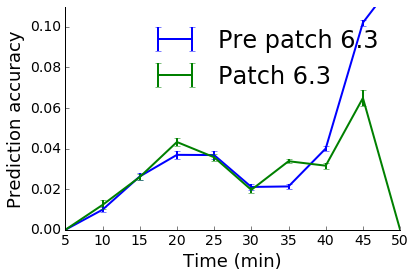

In [130]:
plt.errorbar(time_indices, patch62_dragon_means, patch62_dragon_stes, label = 'Pre patch 6.3')
plt.errorbar(time_indices, patch63_dragon_means, patch63_dragon_stes, label = 'Patch 6.3')
plt.ylim( 0, 0.11)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(frameon=False);

## Dragon importance using Naive Bayes

In [142]:
dragon_bayes = GaussianNB()
def get_NB_prediction(cur_df, col_name):
    num_samples = 2000
    cur_sample = cur_df.sample( min(cur_df.shape[0], num_samples) ) 
    oob_sample = cur_df.sample( min(cur_df.shape[0], num_samples) ) 
    dragon_bayes.fit(cur_sample[col_name].reshape(-1,1), cur_sample['winner'])
    return dragon_bayes.score(oob_sample[col_name].reshape(-1,1), oob_sample['winner'])

In [140]:
def bootstrap_NB_scores(timeline_dfs, col_name, num_boots):
    scores = np.zeros([num_boots, 10]) # 3D array of boots, time, and column
    for i in range(num_boots):
        scores[i,:] = list(map( lambda x: get_NB_prediction( x, col_name), patch63_dfs ))
    return scores

In [138]:
get_NB_prediction(patch62_dfs[2], 'drag_diff')

0.60050000000000003

In [143]:
NB_boots = 20
patch62_NB_scores = bootstrap_NB_scores(patch62_dfs, 'drag_diff', NB_boots )
patch63_NB_scores = bootstrap_NB_scores(patch63_dfs, 'drag_diff', NB_boots )

In [150]:
patch62_NB_means = np.mean(patch62_NB_scores, axis = 0)
patch63_NB_means = np.mean(patch63_NB_scores, axis = 0)
patch62_NB_stes = np.std(patch62_NB_scores) / np.sqrt(num_boots)
patch63_NB_stes = np.std(patch63_NB_scores) / np.sqrt(num_boots)

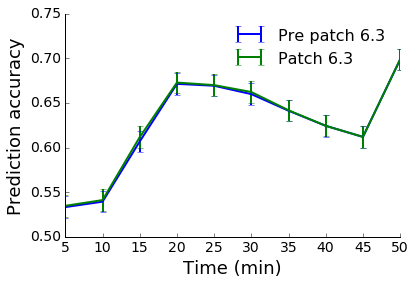

In [154]:
plt.errorbar(time_indices, patch62_NB_means, patch62_NB_stes, label = 'Pre patch 6.3')
plt.errorbar(time_indices, patch63_NB_means, patch63_NB_stes, label = 'Patch 6.3')
#plt.ylim( 0, 0.11)
plt.xlabel('Time (min)', fontsize = 18)
plt.ylabel('Prediction accuracy', fontsize = 18)
plt.xticks(time_indices)
lol_plt.prettify_axes(plt.gca())
plt.legend(frameon=False, fontsize = 16);

## Dragon importance using logistic regression  log odds ratios

In [156]:
dragon_lr = LogisticRegression( n_jobs = -1)
def get_LR_prediction(cur_df, col_name):
    num_samples = 2000
    cur_sample = cur_df.sample( min(cur_df.shape[0], num_samples) ) 
    oob_sample = cur_df.sample( min(cur_df.shape[0], num_samples) ) 
    dragon_lr.fit(cur_sample[col_name].reshape(-1,1), cur_sample['winner'])
    return dragon_lr.score(oob_sample[col_name].reshape(-1,1), oob_sample['winner'])

In [158]:
dragon_lr.fit(patch62_dfs[0]['drag_diff'].reshape(-1,1), patch62_dfs[0]['winner'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [167]:
import math
coef = dragon_lr.coef_[0][0]
intercept = dragon_lr.intercept_[0]

In [170]:
from scipy.stats import logistic

In [173]:
logistic.cdf( coef + intercept )

0.34430744446443762